# **Extract unique nodes from both datasets.**
* Identify common nodes.
* Filter the hypergraph to include only common nodes and non-empty relations.
* Filter the graph to retain edges where both nodes are common.
* Save the filtered datasets to new files.:

In [1]:
# Define file paths
hypergraph_path = "CYC2008_hypergraph.txt"
graph_path = "Collin_CYC_Graph.txt"

# Load the files
with open(hypergraph_path, 'r') as file:
    hypergraph_data = file.readlines()

with open(graph_path, 'r') as file:
    graph_data = file.readlines()

# Extract unique nodes from both datasets
hypergraph_nodes = set()
for line in hypergraph_data:
    hypergraph_nodes.update(line.split())

graph_nodes = set()
for line in graph_data:
    graph_nodes.update(line.split())

# Find the intersection of nodes
common_nodes = hypergraph_nodes.intersection(graph_nodes)

# Filter the hypergraph: Keep only nodes in common_nodes, discard empty relations
filtered_hypergraph_data = [
    " ".join([node for node in line.split() if node in common_nodes])
    for line in hypergraph_data
]
filtered_hypergraph_data = [line for line in filtered_hypergraph_data if line.strip()]

# Filter the graph: Keep edges where both nodes are in common_nodes
filtered_graph_data = [
    line for line in graph_data
    if all(node in common_nodes for node in line.split())
]

# Save the filtered datasets to new files
modified_hypergraph_path = "Modified_CYC2008_hypergraph.txt"
modified_graph_path = "Modified_Collin_CYC_Graph.txt"

with open(modified_hypergraph_path, 'w') as file:
    file.writelines(line + '\n' for line in filtered_hypergraph_data)

with open(modified_graph_path, 'w') as file:
    file.writelines(filtered_graph_data)

print(f"Modified hypergraph saved to: {modified_hypergraph_path}")
print(f"Modified graph saved to: {modified_graph_path}")


Modified hypergraph saved to: Modified_CYC2008_hypergraph.txt
Modified graph saved to: Modified_Collin_CYC_Graph.txt


In [2]:
!pip install hypernetx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


# **Spectral Clusturing**
[hypernetx referrence](https://github.com/pnnl/HyperNetX/blob/master/hypernetx/algorithms/laplacians_clustering.py)

In [24]:
import numpy as np
from scipy.sparse import diags
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    precision_score,
    recall_score,
    f1_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    silhouette_score,
)
import matplotlib.pyplot as plt


def load_graph(filepath):
    edges = []
    nodes = set()
    with open(filepath, "r") as f:
        for line in f:
            u, v = line.strip().split()
            edges.append((u, v))
            nodes.update([u, v])
    nodes = sorted(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}

    # adjacency matrix
    num_nodes = len(nodes)
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=float)
    for u, v in edges:
        adjacency_matrix[node_index[u], node_index[v]] = 1.0
        adjacency_matrix[node_index[v], node_index[u]] = 1.0  # Undirected graph
    return nodes, adjacency_matrix


def load_hypergraph(filepath):
    nodes = set()
    edges = []
    with open(filepath, "r") as f:
        for line in f:
            edge = line.strip().split()
            edges.append(edge)
            nodes.update(edge)
    nodes = sorted(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}

    # incidence matrix
    num_nodes = len(nodes)
    num_edges = len(edges)
    incidence_matrix = np.zeros((num_nodes, num_edges), dtype=float)
    for j, edge in enumerate(edges):
        for node in edge:
            incidence_matrix[node_index[node], j] = 1.0
    return nodes, incidence_matrix


def compute_graph_laplacian(adjacency_matrix):
    degrees = np.sum(adjacency_matrix, axis=1)
    D_inv_sqrt = diags(1.0 / np.sqrt(degrees + 1e-9))
    laplacian = np.eye(adjacency_matrix.shape[0]) - D_inv_sqrt @ adjacency_matrix @ D_inv_sqrt
    return laplacian


def compute_hypergraph_laplacian(incidence_matrix):
    degrees_nodes = np.sum(incidence_matrix, axis=1)
    degrees_edges = np.sum(incidence_matrix, axis=0)
    Dv_inv_sqrt = diags(1.0 / np.sqrt(degrees_nodes + 1e-9))
    De_inv = diags(1.0 / degrees_edges)
    laplacian = np.eye(incidence_matrix.shape[0]) - Dv_inv_sqrt @ incidence_matrix @ De_inv @ incidence_matrix.T @ Dv_inv_sqrt
    return laplacian


def spectral_clustering(laplacian, num_clusters):
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
    spectral_embedding = eigenvectors[:, :num_clusters]  # Take the first 'num_clusters' eigenvectors
    spectral_embedding = normalize(spectral_embedding, axis=1)  # Normalize rows
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=1)  # Reduced n_init
    labels = kmeans.fit_predict(spectral_embedding)
    return labels


def find_optimal_clusters_based_on_eigenvalue_gap(laplacian, max_clusters=150):
    eigenvalues, _ = np.linalg.eigh(laplacian)
    eigenvalue_diffs = np.diff(eigenvalues)
    optimal_clusters = np.argmax(eigenvalue_diffs) + 1  # +1 because the index starts from 0
    optimal_clusters = min(optimal_clusters, max_clusters)

    #plt.figure(figsize=(8, 6))
    #plt.plot(eigenvalues, label="Eigenvalues")
    #plt.plot(np.arange(1, len(eigenvalue_diffs) + 1), eigenvalue_diffs, label="Eigenvalue Differences", linestyle="--")
    #plt.title("Eigenvalue Spectrum and Differences")
    #plt.xlabel("Index")
    #plt.ylabel("Eigenvalue / Difference")
    #plt.legend()
    #plt.show()

    return optimal_clusters


def save_communities(nodes, labels, output_file):
    communities = {}
    for node, label in zip(nodes, labels):
        if label not in communities:
            communities[label] = []
        communities[label].append(node)

    with open(output_file, "w") as f:
        for community, members in communities.items():
            f.write(f"Community {community}: {','.join(members)}\n")
    return communities


def find_common_nodes(graph_partition, hypergraph_partition):
    graph_nodes = set(graph_partition.keys())
    hypergraph_nodes = set(hypergraph_partition.keys())
    common_nodes = graph_nodes.intersection(hypergraph_nodes)
    if not common_nodes:
        print("No common nodes found between graph and hypergraph.")
    return common_nodes


def evaluate_clustering_metrics(graph_partition, hypergraph_partition):
    common_nodes = find_common_nodes(graph_partition, hypergraph_partition)
    if not common_nodes:
        return

    true_labels = [hypergraph_partition[node] for node in common_nodes]
    pred_labels = [graph_partition[node] for node in common_nodes]

    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average="weighted", zero_division=0)
    recall = recall_score(true_labels, pred_labels, average="weighted", zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    print("\nEvaluation Metrics:")
    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")


# Main Execution
graph_file = "Modified_Collin_CYC_Graph.txt"
hypergraph_file = "Modified_CYC2008_hypergraph.txt"

graph_nodes, graph_adjacency = load_graph(graph_file)
hypergraph_nodes, hypergraph_incidence = load_hypergraph(hypergraph_file)

graph_laplacian = compute_graph_laplacian(graph_adjacency)
hypergraph_laplacian = compute_hypergraph_laplacian(hypergraph_incidence)

print("Analyzing graph...")
optimal_clusters_graph = find_optimal_clusters_based_on_eigenvalue_gap(graph_laplacian, max_clusters=150)

print(f"Optimal number of clusters for graph: {optimal_clusters_graph}")

print("Analyzing hypergraph...")
optimal_clusters_hypergraph = find_optimal_clusters_based_on_eigenvalue_gap(hypergraph_laplacian, max_clusters=150)

print(f"Optimal number of clusters for hypergraph: {optimal_clusters_hypergraph}")

graph_labels = spectral_clustering(graph_laplacian, optimal_clusters_graph)
hypergraph_labels = spectral_clustering(hypergraph_laplacian, optimal_clusters_hypergraph)

graph_communities = save_communities(graph_nodes, graph_labels, "graph_communities.txt")
hypergraph_communities = save_communities(hypergraph_nodes, hypergraph_labels, "hypergraph_communities.txt")

print("Communities saved as 'graph_communities.txt' and 'hypergraph_communities.txt'")

# Convert communities to partition mappings
graph_partition = {node: label for label, nodes in graph_communities.items() for node in nodes}
hypergraph_partition = {node: label for label, nodes in hypergraph_communities.items() for node in nodes}

print("\nEvaluating clustering metrics...")
evaluate_clustering_metrics(graph_partition, hypergraph_partition)


Analyzing graph...
Optimal number of clusters for graph: 150
Analyzing hypergraph...
Optimal number of clusters for hypergraph: 150
Communities saved as 'graph_communities.txt' and 'hypergraph_communities.txt'

Evaluating clustering metrics...

Evaluation Metrics:
NMI: 0.8685
ARI: 0.4405
Precision: 0.0316
Recall: 0.0702
F1 Score: 0.0411
Homogeneity: 0.8539
Completeness: 0.8836
V-measure: 0.8685


<ipython-input-30-bc016589990a>:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best", fontsize=10)


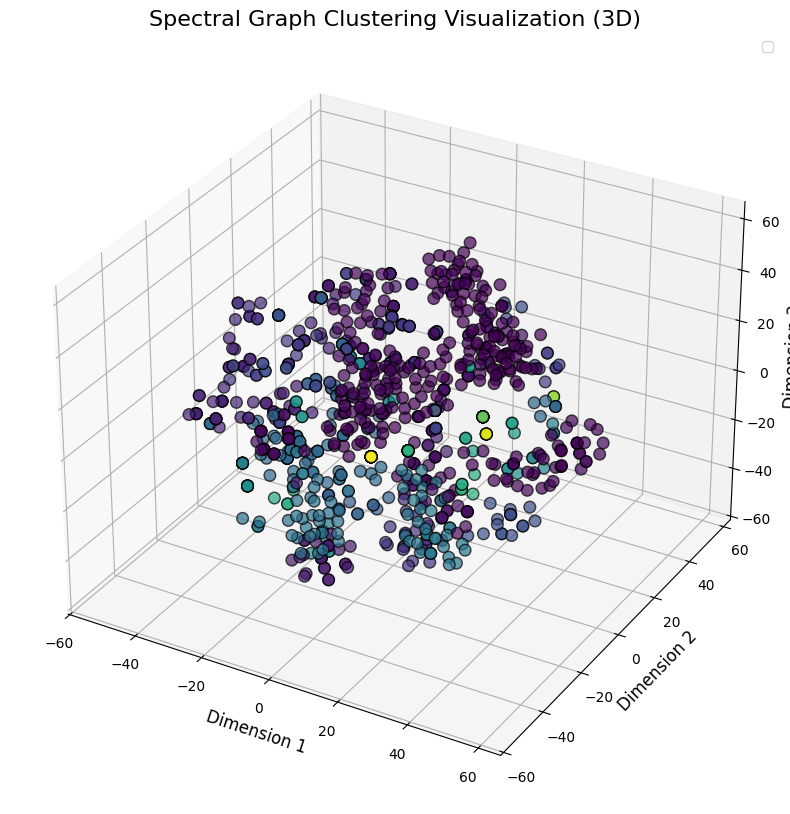

<ipython-input-30-bc016589990a>:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best", fontsize=10)


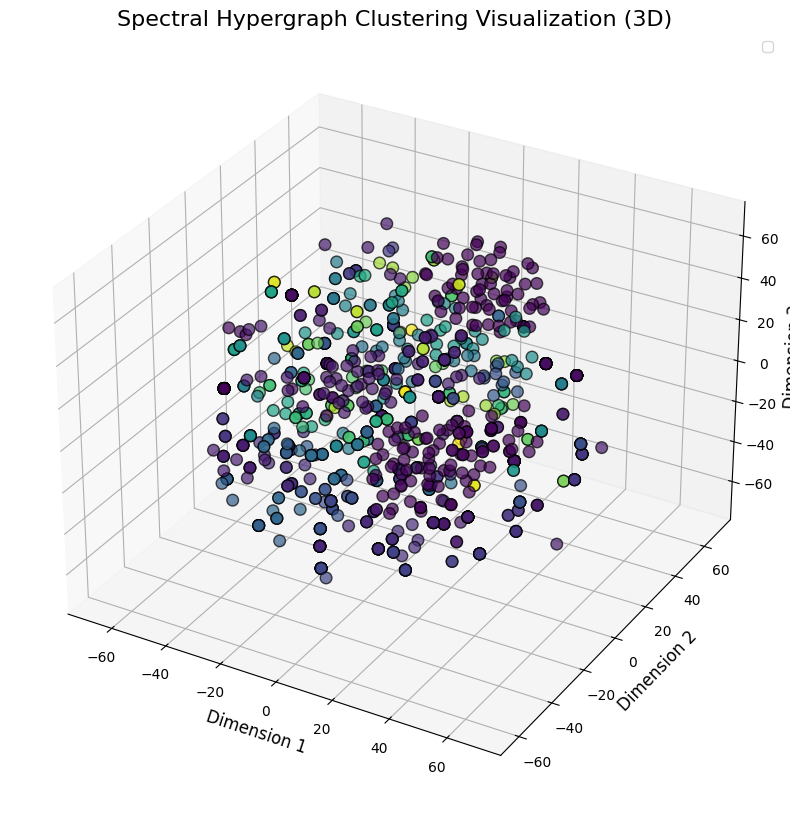

In [30]:
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

def visualize_clusters_3d(data, labels, title="Cluster Visualization (3D)", method="tsne", centroids=None):
    if method == "pca":
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=3)
    elif method == "tsne":
        reducer = TSNE(n_components=3, random_state=42, perplexity=30)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'.")

    reduced_data = reducer.fit_transform(data)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(labels)
    palette = sns.color_palette("viridis", len(unique_labels))

    for label, color in zip(unique_labels, palette):
        idx = np.where(labels == label)
        ax.scatter(
            reduced_data[idx, 0],
            reduced_data[idx, 1],
            reduced_data[idx, 2],
            c=[color],
            #label=f"Cluster {label}",
            alpha=0.7,
            edgecolors="k",
            s=70,
        )

    if centroids is not None:
        reduced_centroids = reducer.fit_transform(centroids)
        ax.scatter(
            reduced_centroids[:, 0],
            reduced_centroids[:, 1],
            reduced_centroids[:, 2],
            c="red",
            marker="x",
            s=150,
            label="Centroids",
            linewidths=2,
        )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Dimension 1", fontsize=12)
    ax.set_ylabel("Dimension 2", fontsize=12)
    ax.set_zlabel("Dimension 3", fontsize=12)
    ax.legend(loc="best", fontsize=10)
    plt.show()


# 3D Visualization of Graph and Hypergraph Clusters
visualize_clusters_3d(graph_embedding, graph_labels, title="Spectral Graph Clustering Visualization (3D)", method="tsne")
visualize_clusters_3d(hypergraph_embedding, hypergraph_labels, title="Spectral Hypergraph Clustering Visualization (3D)", method="tsne")


In [17]:
!pip install hypernetx --upgrade


In [ ]:
pip install goatools

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 9.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=f302e73c56a508a279908258cc1727399c95dd65139e38cc529f1fc1506f4dae
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt


***GeneToGoList***

Previous



In [ ]:
# Step 1: Specify the input and output file names
input_file = "sgd.gaf"  # Replace with the name of your input GAF file
output_file = "output_modified.gaf"   # Name for the modified file

def process_gaf_file(input_file, output_file):
    try:
        with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
            for line in infile:
                # Ignore header lines starting with "!"
                if line.startswith("!"):
                    outfile.write(line)
                    continue

                # Split the tab-delimited row
                columns = line.strip().split('\t')

                # Modify the 11th column to remove everything after '|'
                if len(columns) > 10:  # Ensure there is an 11th column
                    columns[10] = '|'.join(columns[10].split('|')[:1])

                # Write the modified line to the new file
                outfile.write('\t'.join(columns) + '\n')

        print(f"Modified file saved as: {output_file}")
    except FileNotFoundError:
        print(f"Error: File {input_file} not found. Please check the file name and try again.")

# Step 2: Process the file
process_gaf_file(input_file, output_file)

# Notify the user
print(f"Processing complete. The modified file is saved as '{output_file}' in the current working directory.")

Modified file saved as: output_modified.gaf
Processing complete. The modified file is saved as 'output_modified.gaf' in the current working directory.


In [ ]:
from collections import defaultdict

input_gaf_file = "output_modified.gaf"
output_file = "gene2golist2.txt"

# Step 2: Process the GAF file to extract systematic names and GO terms
def gaf_to_gene2golist(input_file, output_file):
    gene_to_go = defaultdict(set)

    try:
        with open(input_file, "r") as infile:
            for line in infile:
                if line.startswith("!"):  # Skip comment lines
                    continue

                columns = line.strip().split("\t")
                if len(columns) < 12:
                    continue  # Skip malformed lines

                # Extract systematic name and GO term
                systematic_name = columns[10]  # Column 11 (0-indexed)
                go_term = columns[4]           # Column 5 (0-indexed)

                # Filter for systematic names starting with "Y"
                if systematic_name.startswith("Y"):
                    gene_to_go[systematic_name].add(go_term)

        # Write results to the output file
        with open(output_file, "w") as outfile:
            for gene, go_terms in sorted(gene_to_go.items()):
                go_term_list = ";".join(sorted(go_terms))
                outfile.write(f"{gene}\t{go_term_list}\n")

        print(f"Conversion complete! Results saved in {output_file}")
    except FileNotFoundError:
        print(f"Error: File {input_file} not found. Please check the file name and try again.")

# Step 3: Run the function
gaf_to_gene2golist(input_gaf_file, output_file)

# Step 4: Notify the user
print(f"Output file '{output_file}' is ready. Check your current working directory.")


Conversion complete! Results saved in gene2golist2.txt
Output file 'gene2golist2.txt' is ready. Check your current working directory.


# ***Go enrichment***

In [ ]:
import os
from collections import defaultdict
from goatools.obo_parser import GODag
from goatools.goea.go_enrichment_ns import GOEnrichmentStudy
import sys

In [ ]:
def load_gene2go(file_path):
    """Load the gene-to-GO mapping file into a dictionary."""
    gene2go = defaultdict(set)
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            gene = parts[0]
            go_terms = parts[1].split(';') if len(parts) > 1 else []
            for go_term in go_terms:
                gene2go[gene].add(go_term)
    return dict(gene2go)

In [ ]:
def load_population(file_path):
    """Load the population file into a set."""
    with open(file_path, 'r') as file:
        return set(line.strip() for line in file)

In [ ]:
def load_communities(file_path):
    """Load the communities file into a dictionary."""
    communities = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(':')
            if len(parts) != 2:
                raise ValueError(f"Invalid format in communities file: {line}")
            community_id = parts[0].strip()
            genes = set(parts[1].split(','))
            communities[community_id] = genes
    return communities

In [ ]:
def perform_enrichment_analysis_with_goatools(community_id, community_genes, population, gene2go, go_dag, output_file, significant_genes, pval_threshold=0.05):
    """
    Perform Gene Ontology enrichment analysis for a single community using GOATOOLS.
    """
    # Create the GO enrichment object
    goea_obj = GOEnrichmentStudy(
        population,  # Background population
        gene2go,     # Gene-to-GO mapping
        go_dag,      # Gene Ontology DAG
        methods=['fdr_bh'],  # Multiple test correction
        log=sys.stdout  # Debug output
    )

    # Perform the enrichment analysis
    results = goea_obj.run_study(community_genes)

    # Calculate GO term frequencies in the population
    go_population_count = defaultdict(int)
    for gene in population:
        for go_term in gene2go.get(gene, []):
            go_population_count[go_term] += 1

    # Calculate GO term frequencies in the community
    go_community_count = defaultdict(int)
    for gene in community_genes:
        for go_term in gene2go.get(gene, []):
            go_community_count[go_term] += 1

    # Write results for this community in TSV format
    with open(output_file, 'w') as file:
        # Write the header row
        #print(f"GO Term: {res.GO}, Raw P-value: {res.p_uncorrected:.6f}, FDR: {res.p_fdr_bh:.6f}")  # Debugging output

        file.write("GO_Term\tDescription\tP-value\tOdds_Ratio\tFDR\tSignificant_Genes\tGenes_in_Community\tGenes_in_Population\n")

        # Write each result as a row
        for res in results:
            if res.p_fdr_bh <= pval_threshold:
                go_term_genes_in_community = go_community_count[res.GO]
                go_term_genes_in_population = go_population_count[res.GO]

                file.write(f"{res.GO}\t{res.name}\t{res.p_uncorrected:.6f}\t"
                           f"{res.ratio_in_study[0]/res.ratio_in_study[1]:.4f}\t"
                           f"{res.p_fdr_bh:.6f}\t{','.join(res.study_items)}\t"
                           f"{go_term_genes_in_community}\t{go_term_genes_in_population}\n")

                # Add significant genes to the set
                significant_genes[community_id].update(res.study_items)

In [ ]:
# Define the file path (update if needed)
communities_file = "graph_communities.txt"  # Update with your uploaded file name
output_population_file = "population_list.txt"

def extract_population_from_communities(input_file, output_file):
    """
    Extract all unique genes from community data and save as a population list.

    Args:
        input_file (str): Path to the communities file.
        output_file (str): Path to save the population list.

    Returns:
        None
    """
    population_set = set()

    # Read the communities file
    with open(input_file, "r") as f:
        for line in f:
            # Extract genes after the colon and split by commas
            if ":" in line:
                genes = line.strip().split(":")[1].split(",")
                population_set.update(genes)

    # Save the unique genes as the population list
    with open(output_file, "w") as f:
        for gene in sorted(population_set):
            f.write(f"{gene}\n")

    print(f"GOA population list saved to '{output_file}'")

# Call the function to process the file
extract_population_from_communities(communities_file, output_population_file)



GOA population list saved to 'population_list.txt'


In [ ]:
def main_with_goatools(population_file, gene2go_file, communities_file, go_obo_file, individual_output_dir, summary_file, pval_threshold=0.05):
    """Main function to run GO enrichment analysis for all communities."""
    # Load data
    population = load_population(population_file)
    gene2go = load_gene2go(gene2go_file)
    communities = load_communities(communities_file)
    go_dag = GODag(go_obo_file)

    # Create output directory if it doesn't exist
    os.makedirs(individual_output_dir, exist_ok=True)

    # Dictionary to store significant genes for each community
    significant_genes = defaultdict(set)

    # Perform enrichment analysis for each community
    for community_id, community_genes in communities.items():
        print(f"Processing Community {community_id} with {len(community_genes)} genes...")

        matched_genes = [gene for gene in community_genes if gene in gene2go]
        if not matched_genes:
            print(f"Warning: No matching GO terms for community {community_id}. Skipping...")
            continue

        output_file = os.path.join(individual_output_dir, f"Graph_community_{community_id}_enrichment.tsv")

        perform_enrichment_analysis_with_goatools(
            community_id, community_genes, population, gene2go, go_dag, output_file, significant_genes, pval_threshold
        )

    # Write summary file in TSV format
    with open(summary_file, 'w') as file:
        file.write("Community\tSignificant_Genes\n")
        for community_id, genes in significant_genes.items():
            file.write(f"{community_id}\t{','.join(genes)}\n")

**for graph**

In [ ]:
if __name__ == "__main__":
    try:
        main_with_goatools(
            population_file="population_list.txt",
            gene2go_file="gene2golist2.txt",
            communities_file="graph_communities.txt",
            go_obo_file="go-basic.obo",
            individual_output_dir="Graph_enrichment",
            summary_file="Graph_enrichment_result.tsv",
            pval_threshold=0.05
        )
    except Exception as e:
        print(f"An error occurred: {e}")


go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
Processing Community Community 28 with 6 genes...

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  1,097 of  1,097 population items found in association

Runing  Ontology Analysis: current study set of 6 IDs.
100%      5 of      5 study items found in association
 83%      5 of      6 study items found in population(1097)
Calculating 3,574 uncorrected p-values using fisher_scipy_stats
   3,574 terms are associated with  1,097 of  1,097 population items
      63 terms are associated with      5 of      6 study items
  METHOD fdr_bh:
      26 GO terms found significant (< 0.05=alpha) ( 26 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
Processing Community Community 25 with 7 genes...

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  1,097 of  1,097 

In [ ]:
import csv

def convert_tsv_to_txt(input_file, output_file):
    """
    Converts a TSV file to a TXT file.
    """
    with open(input_file, 'r') as tsv_file, open(output_file, 'w') as txt_file:
        reader = csv.reader(tsv_file, delimiter='\t')
        for row in reader:
            txt_file.write('\t'.join(row) + '\n')

input_tsv = 'Graph_enrichment_result.tsv'
output_txt = 'Graph_enrichment_result_summary.tsv'
convert_tsv_to_txt(input_tsv, output_txt)

**graph Community result**

In [ ]:
def analyze_communities(communities_file, enriched_communities_file):
    """
    Analyzes communities and calculates:
        1. Percentage of communities with at least one significant gene.
        2. Percentage of genes within enriched communities.
    """
    with open(communities_file, 'r') as f:
        all_communities = [line.strip().split(": ")[1].split(",") for line in f if line.startswith("Community")]

    with open(enriched_communities_file, 'r') as f:
        enriched_communities_dict = {}
        for line in f:
            if line.startswith("Community"):
                community, genes = line.strip().split("\t")
                enriched_communities_dict[community] = genes.split(",")

    total_genes = sum(len(community) for community in all_communities)
    enriched_genes = sum(len(genes) for genes in enriched_communities_dict.values())
    enriched_count = len(enriched_communities_dict)

    percentage_enriched_communities = (enriched_count / len(all_communities)) * 100
    percentage_enriched_genes = (enriched_genes / total_genes) * 100

    return percentage_enriched_communities, percentage_enriched_genes

communities_file = "graph_communities.txt"
enriched_communities_file = "Graph_enrichment_result_summary.tsv"
community_percentage, gene_percentage = analyze_communities(communities_file, enriched_communities_file)

print(f"Percentage of communities with at least one significant gene: {community_percentage:.2f}%")
print(f"Percentage of genes within enriched communities: {gene_percentage:.2f}%")

Percentage of communities with at least one significant gene: 56.67%
Percentage of genes within enriched communities: 79.76%


***Hypergraph***

In [ ]:
if __name__ == "__main__":
    try:
        main_with_goatools(
            population_file="population_list.txt",
            gene2go_file="gene2golist2.txt",
            communities_file="hypergraph_communities.txt",
            go_obo_file="go-basic.obo",
            individual_output_dir="HyperGraph_enrichment",
            summary_file="HyperGraph_enrichment_result.tsv",
            pval_threshold=0.05
        )
    except Exception as e:
        print(f"An error occurred: {e}")


go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
Processing Community Community 27 with 6 genes...

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  1,097 of  1,097 population items found in association

Runing  Ontology Analysis: current study set of 6 IDs.
100%      5 of      5 study items found in association
 83%      5 of      6 study items found in population(1097)
Calculating 3,574 uncorrected p-values using fisher_scipy_stats
   3,574 terms are associated with  1,097 of  1,097 population items
      63 terms are associated with      5 of      6 study items
  METHOD fdr_bh:
      26 GO terms found significant (< 0.05=alpha) ( 26 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
Processing Community Community 42 with 7 genes...

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  1,097 of  1,097 

In [ ]:
import csv

def convert_tsv_to_txt(input_file, output_file):
    """
    Converts a TSV file to a TXT file.
    """
    with open(input_file, 'r') as tsv_file, open(output_file, 'w') as txt_file:
        reader = csv.reader(tsv_file, delimiter='\t')
        for row in reader:
            txt_file.write('\t'.join(row) + '\n')

input_tsv = 'HyperGraph_enrichment_result.tsv'
output_txt = 'HyperGraph_enrichment_result_summary.tsv'
convert_tsv_to_txt(input_tsv, output_txt)

**Hypergraph Community result**

In [ ]:
def analyze_communities(communities_file, enriched_communities_file):
    """
    Analyzes communities and calculates:
        1. Percentage of communities with at least one significant gene.
        2. Percentage of genes within enriched communities.
    """
    with open(communities_file, 'r') as f:
        all_communities = [line.strip().split(": ")[1].split(",") for line in f if line.startswith("Community")]

    with open(enriched_communities_file, 'r') as f:
        enriched_communities_dict = {}
        for line in f:
            if line.startswith("Community"):
                community, genes = line.strip().split("\t")
                enriched_communities_dict[community] = genes.split(",")

    total_genes = sum(len(community) for community in all_communities)
    enriched_genes = sum(len(genes) for genes in enriched_communities_dict.values())
    enriched_count = len(enriched_communities_dict)

    percentage_enriched_communities = (enriched_count / len(all_communities)) * 100
    percentage_enriched_genes = (enriched_genes / total_genes) * 100

    return percentage_enriched_communities, percentage_enriched_genes

communities_file = "graph_communities.txt"
enriched_communities_file = "HyperGraph_enrichment_result_summary.tsv"
community_percentage, gene_percentage = analyze_communities(communities_file, enriched_communities_file)

print(f"Percentage of communities with at least one significant gene: {community_percentage:.2f}%")
print(f"Percentage of genes within enriched communities: {gene_percentage:.2f}%")

Percentage of communities with at least one significant gene: 68.00%
Percentage of genes within enriched communities: 79.95%


# **Finding Uniqe GOTerms**



In [ ]:
import os
from collections import defaultdict
from goatools.obo_parser import GODag
from goatools.goea.go_enrichment_ns import GOEnrichmentStudy
import csv
import sys


def load_gene2go(file_path):
    """Load the gene-to-GO mapping file into a dictionary."""
    gene2go = defaultdict(set)
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            gene = parts[0]
            go_terms = parts[1].split(';') if len(parts) > 1 else []
            for go_term in go_terms:
                gene2go[gene].add(go_term)
    return dict(gene2go)


def load_communities(file_path):
    """Load the communities file into a dictionary."""
    communities = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(':')
            if len(parts) != 2:
                raise ValueError(f"Invalid format in communities file: {line}")
            community_id = parts[0].strip()
            genes = set(parts[1].split(','))
            communities[community_id] = genes
    return communities


def load_population(file_path):
    """Load the population file into a set."""
    with open(file_path, 'r') as file:
        return set(line.strip() for line in file)


def perform_enrichment_analysis_across_communities(community_id, community_genes, population, gene2go, go_dag, global_go_terms, pval_threshold=0.05):
    """
    Perform Gene Ontology enrichment analysis for a single community and update the global dictionary
    with the lowest p-value for each unique GO term across all communities.
    """
    goea_obj = GOEnrichmentStudy(
        population,  # Background population
        gene2go,     # Gene-to-GO mapping
        go_dag,      # Gene Ontology DAG
        methods=['fdr_bh'],  # Multiple test correction
        log=sys.stdout  # Debug output
    )

    results = goea_obj.run_study(community_genes)

    # Update the global dictionary with the lowest p-value for each unique GO term
    for result in results:
        if result.p_fdr_bh <= pval_threshold:
            go_term = result.GO
            p_value = result.p_fdr_bh
            description = result.name

            # Check if this GO term is already in the global dictionary
            if go_term not in global_go_terms or p_value < global_go_terms[go_term][1]:
                global_go_terms[go_term] = (community_id, p_value, description)


def main_with_global_go_terms(population_file, gene2go_file, communities_file, go_obo_file, output_csv_file, pval_threshold=0.05):
    """Main function to run GO enrichment analysis and create a CSV with unique GO terms across all communities."""
    population = load_population(population_file)
    gene2go = load_gene2go(gene2go_file)
    communities = load_communities(communities_file)
    go_dag = GODag(go_obo_file)

    global_go_terms = {}  # Dictionary to store the lowest p-value for each GO term across all communities

    # Perform enrichment analysis for each community
    for community_id, community_genes in communities.items():
        print(f"Processing Community {community_id} with {len(community_genes)} genes...")
        matched_genes = [gene for gene in community_genes if gene in gene2go]
        if not matched_genes:
            print(f"Warning: No matching GO terms for community {community_id}. Skipping...")
            continue

        perform_enrichment_analysis_across_communities(
            community_id, community_genes, population, gene2go, go_dag, global_go_terms, pval_threshold
        )

    # Write the unique GO terms with the lowest p-values to a CSV file
    with open(output_csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["GO_Term", "Community_ID", "P-value", "Description"])  # Header row
        for go_term, (community_id, p_value, description) in global_go_terms.items():
            writer.writerow([go_term, community_id, p_value, description])


if __name__ == "__main__":
    try:
        main_with_global_go_terms(
            population_file="/content/population_list.txt",  # Path to population file
            gene2go_file="/content/gene2golist2.txt",   # Path to gene-to-GO mapping file
            communities_file="/content/graph_communities.txt",  # Path to communities file
            go_obo_file="/content/go-basic.obo",  # Path to GO DAG file
            output_csv_file="unique_go_terms_graph.csv",  # Output CSV file path
            pval_threshold=0.05  # P-value threshold
        )
    except Exception as e:
        print(f"An error occurred: {e}")


/content/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
Processing Community Community 28 with 6 genes...

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  1,097 of  1,097 population items found in association

Runing  Ontology Analysis: current study set of 6 IDs.
100%      5 of      5 study items found in association
 83%      5 of      6 study items found in population(1097)
Calculating 3,574 uncorrected p-values using fisher_scipy_stats
   3,574 terms are associated with  1,097 of  1,097 population items
      63 terms are associated with      5 of      6 study items
  METHOD fdr_bh:
      26 GO terms found significant (< 0.05=alpha) ( 26 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
Processing Community Community 25 with 7 genes...

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  1,097 o

In [ ]:
import os
from collections import defaultdict
from goatools.obo_parser import GODag
from goatools.goea.go_enrichment_ns import GOEnrichmentStudy
import csv
import sys


def load_gene2go(file_path):
    """Load the gene-to-GO mapping file into a dictionary."""
    gene2go = defaultdict(set)
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            gene = parts[0]
            go_terms = parts[1].split(';') if len(parts) > 1 else []
            for go_term in go_terms:
                gene2go[gene].add(go_term)
    return dict(gene2go)


def load_communities(file_path):
    """Load the communities file into a dictionary."""
    communities = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(':')
            if len(parts) != 2:
                raise ValueError(f"Invalid format in communities file: {line}")
            community_id = parts[0].strip()
            genes = set(parts[1].split(','))
            communities[community_id] = genes
    return communities


def load_population(file_path):
    """Load the population file into a set."""
    with open(file_path, 'r') as file:
        return set(line.strip() for line in file)


def perform_enrichment_analysis_across_communities(community_id, community_genes, population, gene2go, go_dag, global_go_terms, pval_threshold=0.05):
    """
    Perform Gene Ontology enrichment analysis for a single community and update the global dictionary
    with the lowest p-value for each unique GO term across all communities.
    """
    goea_obj = GOEnrichmentStudy(
        population,  # Background population
        gene2go,     # Gene-to-GO mapping
        go_dag,      # Gene Ontology DAG
        methods=['fdr_bh'],  # Multiple test correction
        log=sys.stdout  # Debug output
    )

    results = goea_obj.run_study(community_genes)

    # Update the global dictionary with the lowest p-value for each unique GO term
    for result in results:
        if result.p_fdr_bh <= pval_threshold:
            go_term = result.GO
            p_value = result.p_fdr_bh
            description = result.name

            # Check if this GO term is already in the global dictionary
            if go_term not in global_go_terms or p_value < global_go_terms[go_term][1]:
                global_go_terms[go_term] = (community_id, p_value, description)


def main_with_global_go_terms(population_file, gene2go_file, communities_file, go_obo_file, output_csv_file, pval_threshold=0.05):
    """Main function to run GO enrichment analysis and create a CSV with unique GO terms across all communities."""
    population = load_population(population_file)
    gene2go = load_gene2go(gene2go_file)
    communities = load_communities(communities_file)
    go_dag = GODag(go_obo_file)

    global_go_terms = {}  # Dictionary to store the lowest p-value for each GO term across all communities

    # Perform enrichment analysis for each community
    for community_id, community_genes in communities.items():
        print(f"Processing Community {community_id} with {len(community_genes)} genes...")
        matched_genes = [gene for gene in community_genes if gene in gene2go]
        if not matched_genes:
            print(f"Warning: No matching GO terms for community {community_id}. Skipping...")
            continue

        perform_enrichment_analysis_across_communities(
            community_id, community_genes, population, gene2go, go_dag, global_go_terms, pval_threshold
        )

    # Write the unique GO terms with the lowest p-values to a CSV file
    with open(output_csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["GO_Term", "Community_ID", "P-value", "Description"])  # Header row
        for go_term, (community_id, p_value, description) in global_go_terms.items():
            writer.writerow([go_term, community_id, p_value, description])


if __name__ == "__main__":
    try:
        main_with_global_go_terms(
            population_file="/content/population_list.txt",  # Path to population file
            gene2go_file="/content/gene2golist2.txt",   # Path to gene-to-GO mapping file
            communities_file="/content/hypergraph_communities.txt",  # Path to communities file
            go_obo_file="/content/go-basic.obo",  # Path to GO DAG file
            output_csv_file="unique_go_terms_hypergraph.csv",  # Output CSV file path
            pval_threshold=0.05  # P-value threshold
        )
    except Exception as e:
        print(f"An error occurred: {e}")


/content/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
Processing Community Community 27 with 6 genes...

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  1,097 of  1,097 population items found in association

Runing  Ontology Analysis: current study set of 6 IDs.
100%      5 of      5 study items found in association
 83%      5 of      6 study items found in population(1097)
Calculating 3,574 uncorrected p-values using fisher_scipy_stats
   3,574 terms are associated with  1,097 of  1,097 population items
      63 terms are associated with      5 of      6 study items
  METHOD fdr_bh:
      26 GO terms found significant (< 0.05=alpha) ( 26 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
Processing Community Community 42 with 7 genes...

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  1,097 o

# ***Revigo Analysis***

```

```



Preparing Vendiagram

In [ ]:
import pandas as pd

# Define input and output file paths
input_file = "Revigo_Results.xlsx"  # Update with your uploaded Excel file name
output_file = "Filtered_REvigo_Results.xlsx"  # Output Excel file

# Load the Excel file with multiple sheets
data = pd.read_excel(input_file, sheet_name=None)  # Load all sheets as a dictionary

# Dictionary to store filtered data for each sheet
filtered_sheets = {}

# Iterate through each sheet
for sheet_name, df in data.items():
    # Filter rows where "Representative" column is null
    if "Representative" in df.columns:
        filtered_sheets[sheet_name] = df[df["Representative"].isnull()]
    else:
        print(f"'Representative' column not found in sheet: {sheet_name}")

# Save the filtered data to a new Excel file
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, filtered_df in filtered_sheets.items():
        filtered_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Filtered data saved to '{output_file}'")


Filtered data saved to 'Filtered_REvigo_Results.xlsx'


In [ ]:
import pandas as pd

# Define input and output file paths
input_file = "Revigo_Results.xlsx"  # Update with your uploaded Excel file name
output_file = "Filtered_REvigo_Results.xlsx"  # Output Excel file

# Load the Excel file with multiple sheets
data = pd.read_excel(input_file, sheet_name=None)  # Load all sheets as a dictionary

# Dictionary to store processed data for each sheet
processed_sheets = {}

# Iterate through each sheet
for sheet_name, df in data.items():
    if "Representative" in df.columns:
        # Keep only rows where "Representative" is null
        df = df[df["Representative"].isnull()]
        # Replace all other cells with empty strings
        df.iloc[:, :] = df.where(df["Representative"].isnull(), "")
        processed_sheets[sheet_name] = df
    else:
        print(f"'Representative' column not found in sheet: {sheet_name}")

# Save the processed data to a new Excel file
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, processed_df in processed_sheets.items():
        processed_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Processed data saved to '{output_file}'")


Processed data saved to 'Filtered_REvigo_Results.xlsx'


In [ ]:
xls = pd.ExcelFile('/content/Filtered_REvigo_Results.xlsx')
print(xls.sheet_names)


['BP_G', 'CC_G', 'MF_G', 'BP_HG', 'CC_HG', 'MF_HG']


Total GO terms in Graph: 872
Total GO terms in Hypergraph: 861
Common GO terms: 766
GO terms unique to Graph: 106
GO terms unique to Hypergraph: 95


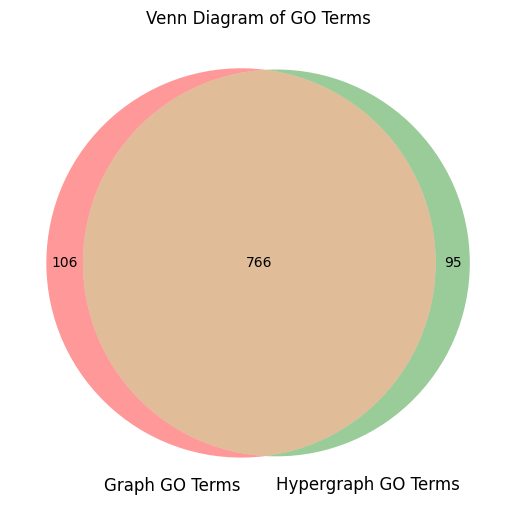

In [ ]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Load the Excel file
input_file = "/content/Filtered_REvigo_Results.xlsx"  # Update with your uploaded Excel file name
data = pd.read_excel(input_file, sheet_name=None)

# Extract GO terms from each sheet
graph_terms = set()
hypergraph_terms = set()

# Sheets for graph and hypergraph
graph_sheets = ['BP_G', 'CC_G', 'MF_G']
hypergraph_sheets = ['BP_HG', 'CC_HG', 'MF_HG']

# Collect GO terms for graph
for sheet in graph_sheets:
    if sheet in data:
        df = data[sheet]
        if 'TermID' in df.columns:
            graph_terms.update(df['TermID'].dropna().tolist())

# Collect GO terms for hypergraph
for sheet in hypergraph_sheets:
    if sheet in data:
        df = data[sheet]
        if 'TermID' in df.columns:
            hypergraph_terms.update(df['TermID'].dropna().tolist())

# Compare GO terms
common_terms = graph_terms.intersection(hypergraph_terms)
graph_only_terms = graph_terms - hypergraph_terms
hypergraph_only_terms = hypergraph_terms - graph_terms

# Print comparison results
print(f"Total GO terms in Graph: {len(graph_terms)}")
print(f"Total GO terms in Hypergraph: {len(hypergraph_terms)}")
print(f"Common GO terms: {len(common_terms)}")
print(f"GO terms unique to Graph: {len(graph_only_terms)}")
print(f"GO terms unique to Hypergraph: {len(hypergraph_only_terms)}")

# Draw Venn diagram
plt.figure(figsize=(8, 6))
venn = venn2(
    subsets=(len(graph_only_terms), len(hypergraph_only_terms), len(common_terms)),
    set_labels=('Graph GO Terms', 'Hypergraph GO Terms')
)
plt.title("Venn Diagram of GO Terms")
plt.show()


Available sheets: ['BP_G', 'CC_G', 'MF_G', 'BP_HG', 'CC_HG', 'MF_HG']


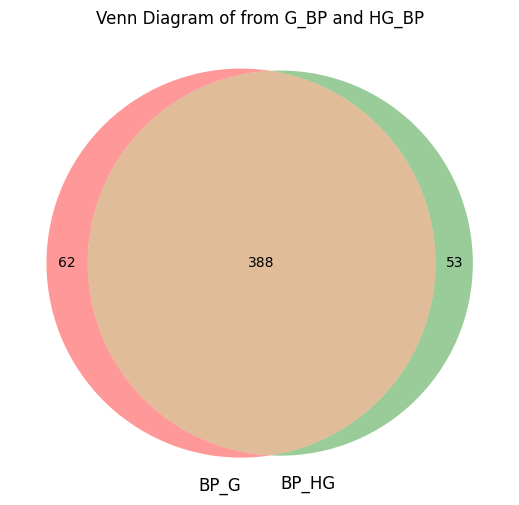

In [ ]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/content/Filtered_REvigo_Results.xlsx'

# Display sheet names to confirm
xls = pd.ExcelFile(file_path)
print("Available sheets:", xls.sheet_names)

# Read the sheets (accounting for the space in 'G_BP_Draft ')
df_g_bp = pd.read_excel(file_path, sheet_name='BP_G')
df_hg_bp = pd.read_excel(file_path, sheet_name='BP_HG')

# Extract TermID values and create sets
set_g_bp = set(df_g_bp['TermID'].dropna())
set_hg_bp = set(df_hg_bp['TermID'].dropna())

# Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn2([set_g_bp, set_hg_bp], ('BP_G', 'BP_HG'))
plt.title('Venn Diagram of from G_BP and HG_BP')
plt.show()


Available sheets: ['BP_G', 'CC_G', 'MF_G', 'BP_HG', 'CC_HG', 'MF_HG']


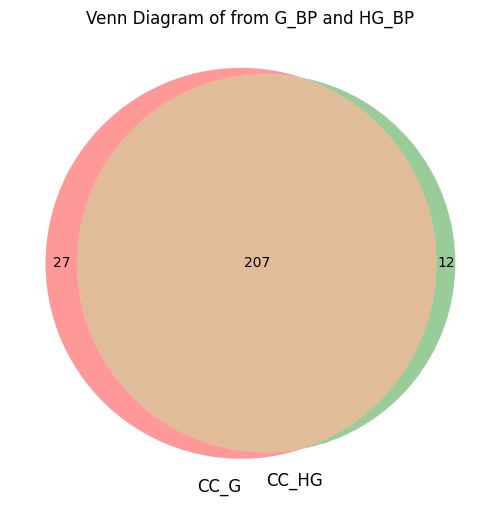

In [ ]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/content/Filtered_REvigo_Results.xlsx'

# Display sheet names to confirm
xls = pd.ExcelFile(file_path)
print("Available sheets:", xls.sheet_names)

# Read the sheets (accounting for the space in 'G_BP_Draft ')
df_g_bp = pd.read_excel(file_path, sheet_name='CC_G')
df_hg_bp = pd.read_excel(file_path, sheet_name='CC_HG')

# Extract TermID values and create sets
set_g_bp = set(df_g_bp['TermID'].dropna())
set_hg_bp = set(df_hg_bp['TermID'].dropna())

# Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn2([set_g_bp, set_hg_bp], ('CC_G', 'CC_HG'))
plt.title('Venn Diagram of from G_BP and HG_BP')
plt.show()


Available sheets: ['BP_G', 'CC_G', 'MF_G', 'BP_HG', 'CC_HG', 'MF_HG']


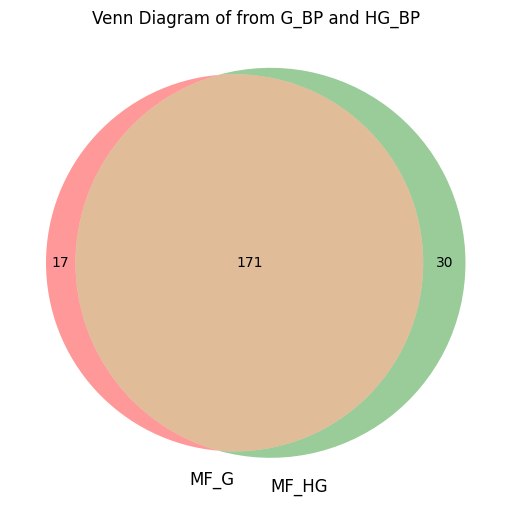

In [ ]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/content/Filtered_REvigo_Results.xlsx'

# Display sheet names to confirm
xls = pd.ExcelFile(file_path)
print("Available sheets:", xls.sheet_names)

# Read the sheets (accounting for the space in 'G_BP_Draft ')
df_g_bp = pd.read_excel(file_path, sheet_name='MF_G')
df_hg_bp = pd.read_excel(file_path, sheet_name='MF_HG')

# Extract TermID values and create sets
set_g_bp = set(df_g_bp['TermID'].dropna())
set_hg_bp = set(df_hg_bp['TermID'].dropna())

# Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn2([set_g_bp, set_hg_bp], ('MF_G', 'MF_HG'))
plt.title('Venn Diagram of from G_BP and HG_BP')
plt.show()


In [ ]:
import pandas as pd

# Load the data from your file
input_file = "/content/Filtered_REvigo_Results.xlsx"  # Update with your file path
data = pd.read_excel(input_file, sheet_name=None)

# List of sheet pairs for comparison
sheet_pairs = [('BP_G', 'BP_HG'), ('CC_G', 'CC_HG'), ('MF_G', 'MF_HG')]

# Initialize sets to store unique GO terms for graph and hypergraph
graph_go_terms = set()
hypergraph_go_terms = set()

# Loop through the sheet pairs and count unique GO terms
for graph_sheet, hypergraph_sheet in sheet_pairs:
    # Check if both sheets exist in the data
    if graph_sheet in data and hypergraph_sheet in data:
        graph_df = data[graph_sheet]
        hypergraph_df = data[hypergraph_sheet]

        # Get unique GO terms (TermID) in both sheets
        unique_go_terms_graph = set(graph_df['TermID'])
        unique_go_terms_hypergraph = set(hypergraph_df['TermID'])

        # Update the total sets
        graph_go_terms.update(unique_go_terms_graph)
        hypergraph_go_terms.update(unique_go_terms_hypergraph)

        # Print the results for each pair
        print(f"Unique GO terms in {graph_sheet}: {len(unique_go_terms_graph)}")
        print(f"Unique GO terms in {hypergraph_sheet}: {len(unique_go_terms_hypergraph)}")
        print("-" * 50)

# Print the total unique GO terms for graph and hypergraph
print(f"Total unique GO terms in graph: {len(graph_go_terms)}")
print(f"Total unique GO terms in hypergraph: {len(hypergraph_go_terms)}")


Unique GO terms in BP_G: 450
Unique GO terms in BP_HG: 441
--------------------------------------------------
Unique GO terms in CC_G: 234
Unique GO terms in CC_HG: 219
--------------------------------------------------
Unique GO terms in MF_G: 188
Unique GO terms in MF_HG: 201
--------------------------------------------------
Total unique GO terms in graph: 872
Total unique GO terms in hypergraph: 861


In [ ]:
# Function to count unique genes in a file
def count_unique_genes(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    # Extract unique genes
    unique_genes = set()
    for line in data:
        unique_genes.update(line.split())

    return len(unique_genes), unique_genes

# File paths
original_hypergraph_path = "CYC2008_hypergraph.txt"  # Replace with your file path
original_graph_path = "Collin_CYC_Graph.txt"        # Replace with your file path
modified_hypergraph_path = "Modified_CYC2008_hypergraph.txt"
modified_graph_path = "Modified_Collin_CYC_Graph.txt"

# Count unique genes in each file
original_hypergraph_count, original_hypergraph_genes = count_unique_genes(original_hypergraph_path)
original_graph_count, original_graph_genes = count_unique_genes(original_graph_path)
modified_hypergraph_count, modified_hypergraph_genes = count_unique_genes(modified_hypergraph_path)
modified_graph_count, modified_graph_genes = count_unique_genes(modified_graph_path)

# Print results
print(f"Original Hypergraph Unique Genes: {original_hypergraph_count}")
print(f"Original Graph Unique Genes: {original_graph_count}")
print(f"Modified Hypergraph Unique Genes: {modified_hypergraph_count}")
print(f"Modified Graph Unique Genes: {modified_graph_count}")

# Verify the common genes
common_genes = original_hypergraph_genes.intersection(original_graph_genes)
print(f"Common Genes Count: {len(common_genes)}")
print(f"Are modified genes consistent with common genes?")
print(f"Hypergraph Consistent: {modified_hypergraph_genes == common_genes}")
print(f"Graph Consistent: {modified_graph_genes == common_genes}")


Original Hypergraph Unique Genes: 1627
Original Graph Unique Genes: 1097
Modified Hypergraph Unique Genes: 1097
Modified Graph Unique Genes: 1097
Common Genes Count: 1097
Are modified genes consistent with common genes?
Hypergraph Consistent: True
Graph Consistent: True
